In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew
from skimage.feature import local_binary_pattern
import joblib
from PIL import Image
from tkinter import filedialog, Tk


In [2]:
# Set seed untuk memastikan hasil reproducible
import random
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Preparation

In [3]:
# Pastikan device didefinisikan sebelum digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Path dataset
train_path = r"D:\Dataset (Uji)\train"
test_path = r"D:\Dataset (Uji)\test"

In [5]:
# Ambil nama folder sebagai class_names (diurutkan secara alfabetis)
class_names = sorted(os.listdir(train_path))
joblib.dump(class_names, "C:/Kuliah/Skripsi/CODE/class_names.pkl")
print(f"Class Names: {class_names}")

Class Names: ['bacterial blight', 'brown spot', 'green mite', 'healthy', 'mosaic']


In [6]:
# Fungsi untuk menampilkan jumlah sampel pada setiap label
def count_samples(dataset_path):
    categories = os.listdir(dataset_path)
    counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
    return counts

# Exploratory Data Analysis (EDA)

Train dataset sample counts: {'bacterial blight': 880, 'brown spot': 880, 'green mite': 880, 'healthy': 880, 'mosaic': 880}
Test dataset sample counts: {'bacterial blight': 220, 'brown spot': 220, 'green mite': 220, 'healthy': 220, 'mosaic': 220}


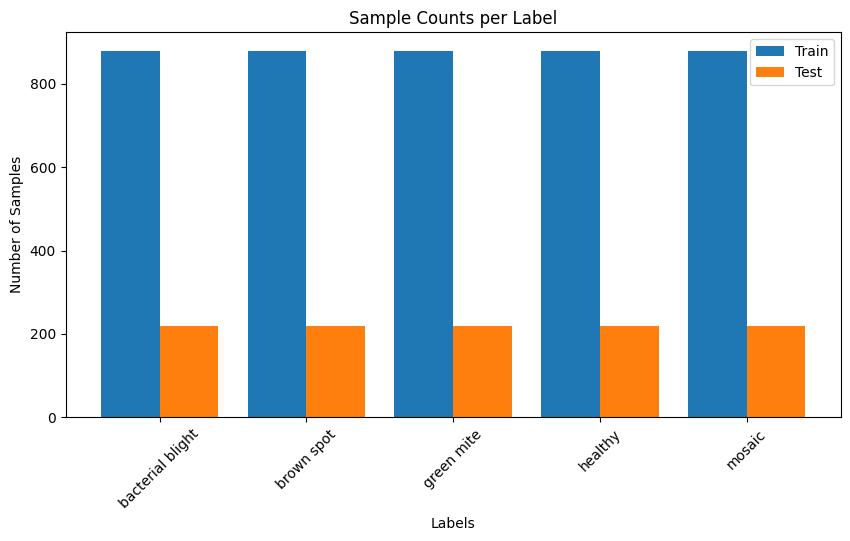

In [7]:
# Menampilkan jumlah sampel
def visualize_sample_counts(train_counts, test_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())
    test_values = list(test_counts.values())
    
    x = np.arange(len(labels))
    width = 0.4
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, train_values, width, label='Train')
    ax.bar(x + width/2, test_values, width, label='Test')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Sample Counts per Label')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    plt.show()

train_counts = count_samples(train_path)
test_counts = count_samples(test_path)
print("Train dataset sample counts:", train_counts)
print("Test dataset sample counts:", test_counts)
visualize_sample_counts(train_counts, test_counts)

Visualisasi dataset training:


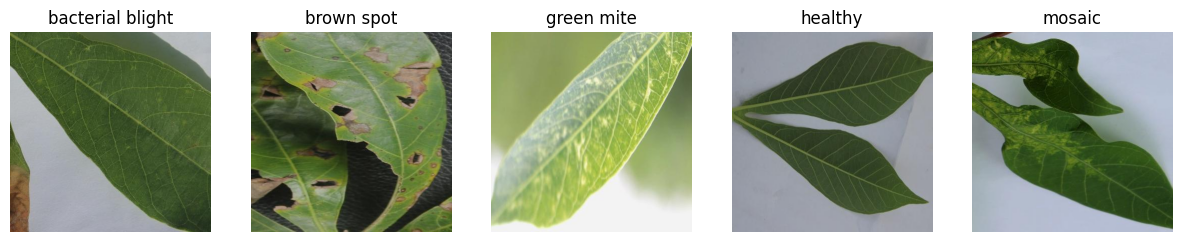

Visualisasi dataset testing:


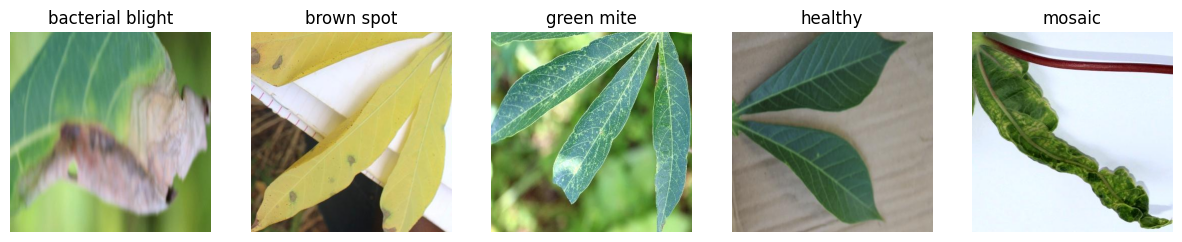

In [8]:
# Visualisasi dataset
def visualize_dataset(dataset_path):
    categories = os.listdir(dataset_path)
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        folder_path = os.path.join(dataset_path, category)
        file_name = os.listdir(folder_path)[0]
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(category)
        axes[i].axis("off")
    plt.show()

print("Visualisasi dataset training:")
visualize_dataset(train_path)
print("Visualisasi dataset testing:")
visualize_dataset(test_path)

# SVM

## Data Preprocessing

In [9]:
# Parameter LBP
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

def extract_features_svm(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Gagal membaca gambar {image_path}")
        return None  # Skip gambar yang tidak bisa dibaca

    image = cv2.resize(image, (224, 224))
    
    # Histogram warna (3 channel, 8 bin per channel)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],
                        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # Color moments (mean, std, skewness untuk setiap channel RGB)
    color_moments = []
    for i in range(3):  # B, G, R
        channel = image[:, :, i]
        color_moments.append(np.mean(channel))
        color_moments.append(np.std(channel))
        color_moments.append(skew(channel.flatten()))
    color_moments = np.array(color_moments)

    # LBP (Local Binary Pattern) dari grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    
    # Histogram LBP
    n_bins = 10
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi

    # Gabungkan semua fitur
    combined_features = np.concatenate([hist, color_moments, lbp_hist])

    return combined_features

In [10]:
# Fungsi untuk memuat dataset untuk SVM
def load_dataset_svm(dataset_path):
    data, labels = [], []
    categories = os.listdir(dataset_path)
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        if not os.path.isdir(folder_path):
            continue
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                features = extract_features_svm(file_path)
                if features is not None:
                    data.append(features)
                    labels.append(categories.index(category))
    return np.array(data), np.array(labels)

In [11]:
# Load dataset untuk SVM
data_train_svm, labels_train_svm = load_dataset_svm(train_path)
data_test_svm, labels_test_svm = load_dataset_svm(test_path)

In [12]:
# Menampilkan jumlah data
print(f"Jumlah data latih: {len(data_train_svm)}")
print(f"Jumlah data uji: {len(data_test_svm)}")

# Menampilkan shape dan contoh data
print(f"Shape fitur latih: {data_train_svm.shape}")
print(f"Shape fitur uji: {data_test_svm.shape}")

# Menampilkan 1 contoh data dan label
print("Contoh fitur (latih):", data_train_svm[0][:10])  # Tampilkan 10 nilai pertama
print("Labelnya:", labels_train_svm[0])

Jumlah data latih: 4400
Jumlah data uji: 1100
Shape fitur latih: (4400, 531)
Shape fitur uji: (1100, 531)
Contoh fitur (latih): [0.         0.         0.         0.         0.         0.
 0.         0.         0.00013973 0.01415952]
Labelnya: 0


##  Standarisai & PCA

In [13]:
# Standarisasi fitur
scaler = StandardScaler()
data_train_svm = scaler.fit_transform(data_train_svm)
data_test_svm = scaler.transform(data_test_svm)

In [14]:
# Reduksi dimensi dengan PCA
pca = PCA(n_components=50)
data_train_svm = pca.fit_transform(data_train_svm)
data_test_svm = pca.transform(data_test_svm)

## Exploratory Data Analysis (EDA)

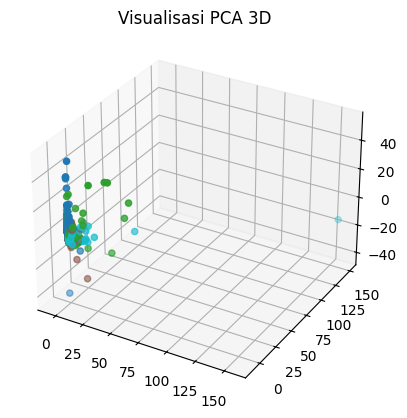

In [15]:
from mpl_toolkits.mplot3d import Axes3D

pca_vis = PCA(n_components=3).fit_transform(data_train_svm)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_vis[:, 0], pca_vis[:, 1], pca_vis[:, 2], c=labels_train_svm, cmap='tab10')
plt.title("Visualisasi PCA 3D")
plt.show()

## Modeling

In [16]:
# Hyperparameter tuning SVM
param_grid = {
    'C': [1, 10],  # Regularisasi
    'gamma': ['scale', 'auto'],  # Parameter untuk kernel RBF
    'kernel': ['linear', 'rbf', 'poly']  # Jenis kernel
}

start_time = time.time()
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(data_train_svm, labels_train_svm)
end_time = time.time()
print(f"Waktu training SVM (GridSearchCV): {end_time - start_time:.2f} detik")

print("Best parameters:", grid.best_params_)
best_svm = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Waktu training SVM (GridSearchCV): 50.79 detik
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [17]:
# Menampilkan hasil dalam bentuk DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Menampilkan hanya kolom penting: parameter dan skor rata-rata
results_table = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_table.sort_values(by='rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
10,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.807273,0.022529,1
11,"{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}",0.783636,0.021580,2
7,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.777045,0.015916,3
4,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.759545,0.024102,4
5,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}",0.755909,0.017800,5
1,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.703409,0.018422,6
8,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.698182,0.010675,7
6,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.685682,0.026108,8
9,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}",0.685682,0.026108,8
0,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.683636,0.024230,10


In [18]:
# Training SVM dengan parameter terbaik
start_time = time.time()
svm = SVC(**grid.best_params_)
svm.fit(data_train_svm, labels_train_svm)
end_time = time.time()
print(f"Waktu training ulang SVM dengan parameter terbaik: {end_time - start_time:.2f} detik")

Waktu training ulang SVM dengan parameter terbaik: 0.53 detik


## Save & Call Model SVM

In [19]:
# Simpan model SVM, PCA, dan Scaler
joblib.dump(svm, "C:/Kuliah/Skripsi/CODE/svm_model.pkl")
joblib.dump(pca, "C:/Kuliah/Skripsi/CODE/pca.pkl")
joblib.dump(scaler, "C:/Kuliah/Skripsi/CODE/scaler.pkl")

['C:/Kuliah/Skripsi/CODE/scaler.pkl']

In [20]:
# Load Model SVM, PCA, dan Scaler
svm_model = joblib.load("C:/Kuliah/Skripsi/CODE/svm_model.pkl")
pca = joblib.load("C:/Kuliah/Skripsi/CODE/pca.pkl")
scaler = joblib.load("C:/Kuliah/Skripsi/CODE/scaler.pkl")

## Hasil Model SVM

Hasil Confusion Matrix, Classification Report, dan Hasil Prediksi

Confusion Matrix (SVM):


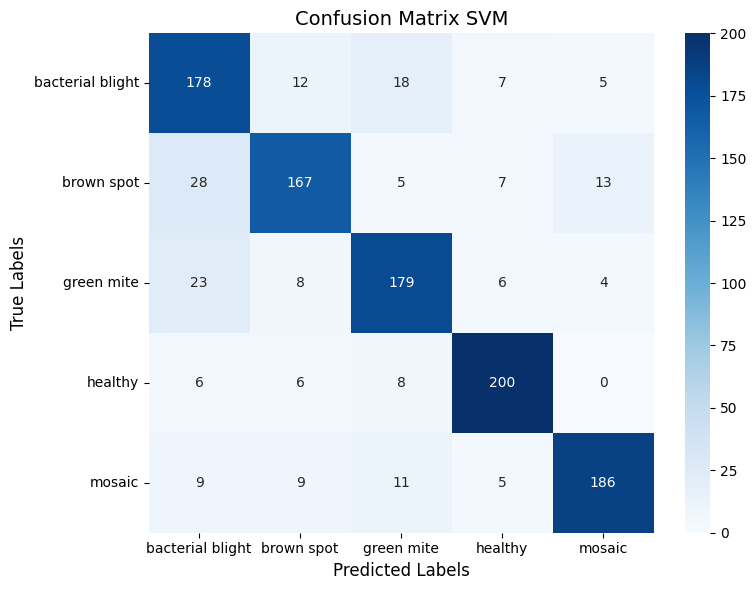

In [21]:
# Evaluasi SVM
y_pred_svm = svm_model.predict(data_test_svm)
y_pred_svm = svm.predict(data_test_svm)

print("Confusion Matrix (SVM):")
cms=confusion_matrix(labels_test_svm, y_pred_svm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cms, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix SVM', fontsize=14)
plt.xticks(rotation=0, ha='center')  
plt.yticks(rotation=0)              
plt.tight_layout()                   
plt.show()

In [22]:
print("\nClassification Report (SVM):")
print(classification_report(labels_test_svm, y_pred_svm, target_names=class_names))


Classification Report (SVM):
                  precision    recall  f1-score   support

bacterial blight       0.73      0.81      0.77       220
      brown spot       0.83      0.76      0.79       220
      green mite       0.81      0.81      0.81       220
         healthy       0.89      0.91      0.90       220
          mosaic       0.89      0.85      0.87       220

        accuracy                           0.83      1100
       macro avg       0.83      0.83      0.83      1100
    weighted avg       0.83      0.83      0.83      1100



In [23]:
# Misal daftar nama kelas sesuai urutan folder
class_names = sorted(os.listdir(test_path))  # atau tulis manual misalnya: ['Sehat', 'Penyakit_A', 'Penyakit_B']

# Buat DataFrame dengan nama kelas
results_df = pd.DataFrame({
    'Actual Label': [class_names[i] for i in labels_test_svm],
    'Predicted Label': [class_names[i] for i in y_pred_svm]
})

print(results_df.head(10))

       Actual Label   Predicted Label
0  bacterial blight  bacterial blight
1  bacterial blight  bacterial blight
2  bacterial blight  bacterial blight
3  bacterial blight  bacterial blight
4  bacterial blight  bacterial blight
5  bacterial blight  bacterial blight
6  bacterial blight  bacterial blight
7  bacterial blight  bacterial blight
8  bacterial blight  bacterial blight
9  bacterial blight        brown spot


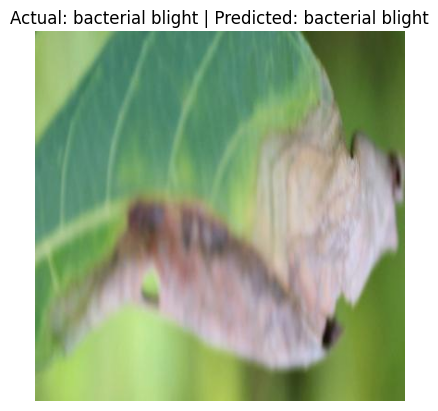

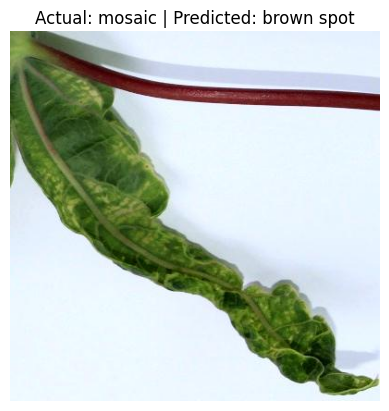

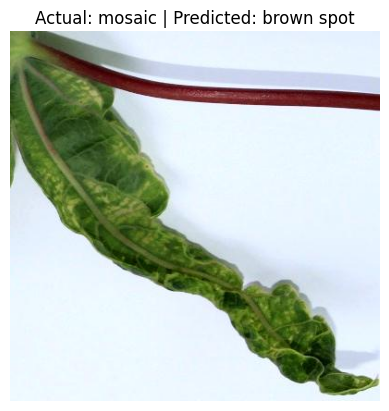

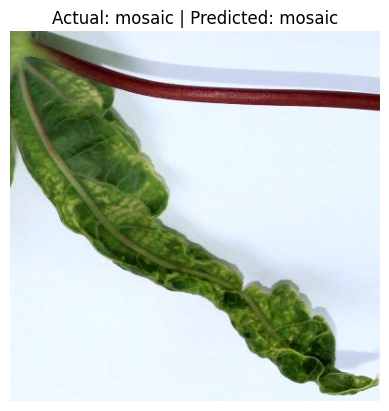

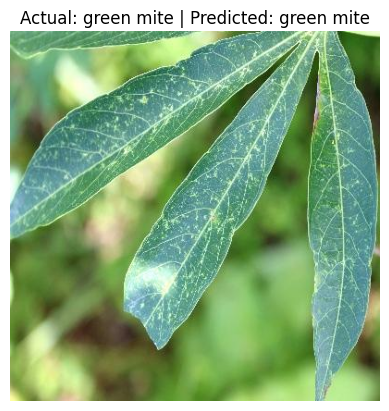

In [24]:
import matplotlib.pyplot as plt

# Tampilkan 5 gambar dari test set beserta prediksi
sample_indices = np.random.choice(len(labels_test_svm), 5, replace=False)

for idx in sample_indices:
    # Path gambar asli dari dataset
    class_folder = class_names[labels_test_svm[idx]]
    test_image_folder = os.path.join(test_path, class_folder)
    test_image_file = os.listdir(test_image_folder)[0]  # asumsi nama gambar urut, bisa diganti lebih tepat
    image_path = os.path.join(test_image_folder, test_image_file)

    # Baca dan tampilkan gambar
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Actual: {class_names[labels_test_svm[idx]]} | Predicted: {class_names[y_pred_svm[idx]]}")
    plt.axis('off')
    plt.show()

# GoogleNet Tanpa Pretrain

## Data Preprocessing

In [7]:
# Inisialisasi dataset googlenet
class ImageDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = os.listdir(dataset_path)
        for label, category in enumerate(self.classes):
            folder_path = os.path.join(dataset_path, category)
            if not os.path.isdir(folder_path):
                continue
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append(file_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

In [26]:
# Transformasi data untuk GoogLeNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
]) 

In [27]:
# DataLoader untuk GoogLeNet
train_dataset = ImageDataset(train_path, transform=transform)
test_dataset = ImageDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Exploratory Data Analysis (EDA)

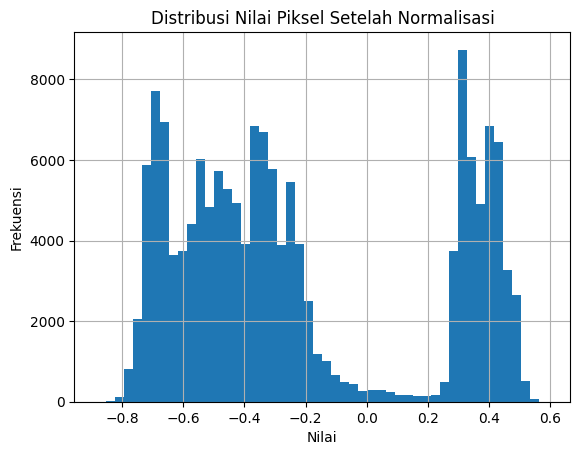

In [28]:
#Distribusi Nilai Piksel Setelah Normalisasi
img, _ = train_dataset[0]
img_np = img.numpy()

plt.hist(img_np.flatten(), bins=50)
plt.title("Distribusi Nilai Piksel Setelah Normalisasi")
plt.xlabel("Nilai")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

In [29]:
# Model GoogLeNet
model = models.googlenet(pretrained=False, aux_logits=False)
model.fc = nn.Linear(1024, len(os.listdir(train_path)))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.eval()

c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

## Modeling

In [30]:
# # Training loop dengan early stopping
# patience = 5            # berhenti jika tidak ada peningkatan selama 5 epoch
# min_delta = 0.005       # peningkatan minimal akurasi agar dianggap signifikan
# wait = 0
# best_test_acc = 0.0

# train_losses, test_losses = [], []
# train_accuracies, test_accuracies = [], []

# epoch = 0
# while True:
#     epoch += 1
#     model.train()
#     running_loss = 0.0
#     correct_train, total_train = 0, 0
#     start_time = time.time()

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct_train += (predicted == labels).sum().item()
#         total_train += labels.size(0)

#     train_loss = running_loss / len(train_loader)
#     train_acc = correct_train / total_train
#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)

#     # Evaluation
#     model.eval()
#     test_loss = 0.0
#     correct_test, total_test = 0, 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             correct_test += (predicted == labels).sum().item()
#             total_test += labels.size(0)

#     test_loss /= len(test_loader)
#     test_acc = correct_test / total_test
#     test_losses.append(test_loss)
#     test_accuracies.append(test_acc)

#     print(f"[{epoch:02d}] ⏱ {time.time() - start_time:.1f}s | "
#           f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
#           f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

#     # Cek apakah model membaik secara signifikan
#     if test_acc > best_test_acc + min_delta:
#         best_test_acc = test_acc
#         torch.save(model.state_dict(), "C:/Kuliah/Skripsi/CODE/googlenet_model.pth")
#         print(f"✅ Best model disimpan! (Test Acc: {best_test_acc:.4f})")
#         wait = 0  # reset counter
#     else:
#         wait += 1
#         print(f"⚠️  Tidak ada peningkatan berarti selama {wait} epoch.")

#     if wait >= patience:
#         print("⛔ Training dihentikan (early stopping)")
#         break


In [31]:
# Training loop
num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_test_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Evaluation ---
    model.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[{epoch+1:02d}/{num_epochs}] ⏱ {time.time() - start_time:.1f}s | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "C:/Kuliah/Skripsi/CODE/googlenet_model.pth")
        print(f"✅ Best model disimpan! (Test Acc: {best_test_acc:.4f})")

[01/20] ⏱ 368.5s | Train Loss: 1.2906 | Train Acc: 0.4582 | Test Loss: 1.1789 | Test Acc: 0.5155
✅ Best model disimpan! (Test Acc: 0.5155)
[02/20] ⏱ 368.9s | Train Loss: 1.0617 | Train Acc: 0.5727 | Test Loss: 1.1512 | Test Acc: 0.5536
✅ Best model disimpan! (Test Acc: 0.5536)
[03/20] ⏱ 382.8s | Train Loss: 0.9261 | Train Acc: 0.6323 | Test Loss: 0.8728 | Test Acc: 0.6509
✅ Best model disimpan! (Test Acc: 0.6509)
[04/20] ⏱ 358.0s | Train Loss: 0.8293 | Train Acc: 0.6782 | Test Loss: 0.7928 | Test Acc: 0.7027
✅ Best model disimpan! (Test Acc: 0.7027)
[05/20] ⏱ 363.4s | Train Loss: 0.7628 | Train Acc: 0.7130 | Test Loss: 0.7117 | Test Acc: 0.7436
✅ Best model disimpan! (Test Acc: 0.7436)
[06/20] ⏱ 358.2s | Train Loss: 0.6658 | Train Acc: 0.7648 | Test Loss: 0.6388 | Test Acc: 0.7818
✅ Best model disimpan! (Test Acc: 0.7818)
[07/20] ⏱ 358.7s | Train Loss: 0.6060 | Train Acc: 0.7830 | Test Loss: 0.7199 | Test Acc: 0.7536
[08/20] ⏱ 361.5s | Train Loss: 0.5599 | Train Acc: 0.8109 | Test Loss

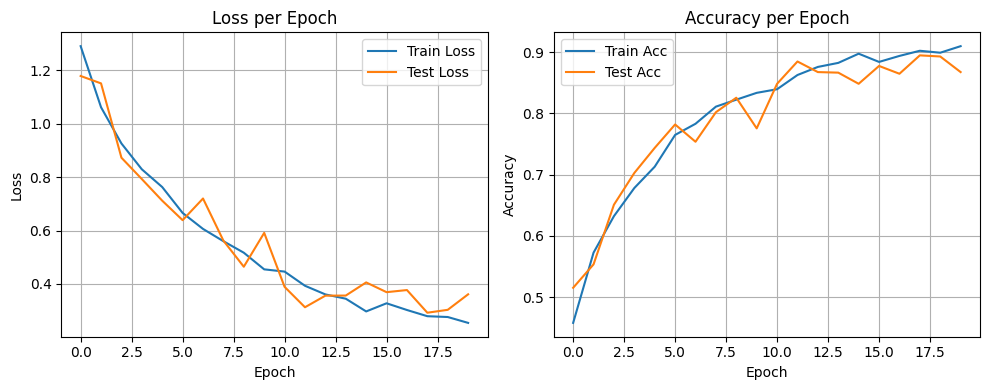

In [32]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Hasil Model

Hasil Confusion Matrix, Classification Report, dan Hasil Prediksi

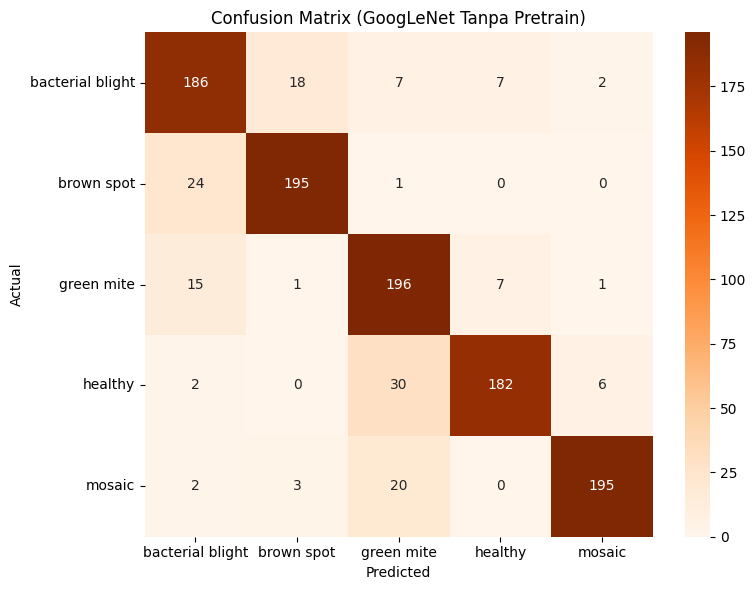

In [33]:
# Confusion Matrix GoogLeNet
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cmgl = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cmgl, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GoogLeNet Tanpa Pretrain)')
plt.xticks(rotation=0, ha='center')  
plt.yticks(rotation=0)              
plt.tight_layout()  
plt.show()

In [34]:
model.load_state_dict(torch.load("C:/Kuliah/Skripsi/CODE/googlenet_model.pth", map_location=device))

C:\Users\P A V I L I O N\AppData\Local\Temp\ipykernel_33516\3338528152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Kuliah/Skrips

<All keys matched successfully>

In [35]:
model.eval()
all_preds = []
all_labels = []
all_paths = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [36]:
print("\nClassification Report (GoogLeNet Tanpa Pretrain):")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report (GoogLeNet Tanpa Pretrain):
                  precision    recall  f1-score   support

bacterial blight       0.89      0.79      0.84       220
      brown spot       0.90      0.92      0.91       220
      green mite       0.83      0.90      0.87       220
         healthy       0.94      0.93      0.94       220
          mosaic       0.91      0.93      0.92       220

        accuracy                           0.89      1100
       macro avg       0.90      0.89      0.89      1100
    weighted avg       0.90      0.89      0.89      1100



In [37]:
# Mendapatkan nama kelas
class_names = sorted(os.listdir(test_path))

# Buat DataFrame
df_results = pd.DataFrame({
    'Actual Label': [class_names[i] for i in all_labels],
    'Predicted Label': [class_names[i] for i in all_preds]
})

print(df_results.head(10))  # Menampilkan 10 prediksi pertama

       Actual Label   Predicted Label
0  bacterial blight        brown spot
1  bacterial blight  bacterial blight
2  bacterial blight  bacterial blight
3  bacterial blight  bacterial blight
4  bacterial blight  bacterial blight
5  bacterial blight  bacterial blight
6  bacterial blight        brown spot
7  bacterial blight  bacterial blight
8  bacterial blight  bacterial blight
9  bacterial blight        brown spot


# Googlenet Pretrain Model

In [38]:
# Inisialisasi dataset googlenet
class ImageDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = os.listdir(dataset_path)
        for label, category in enumerate(self.classes):
            folder_path = os.path.join(dataset_path, category)
            if not os.path.isdir(folder_path):
                continue
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append(file_path)
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

In [39]:
# Transformasi data untuk GoogLeNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
]) 

In [40]:
# DataLoader untuk GoogLeNet
train_dataset = ImageDataset(train_path, transform=transform)
test_dataset = ImageDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

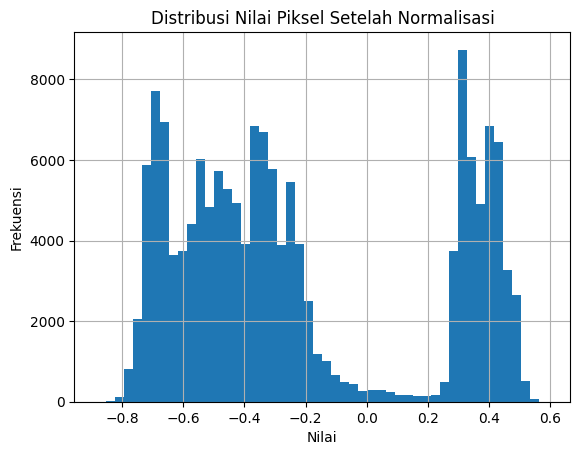

In [41]:
#Distribusi Nilai Piksel Setelah Normalisasi
img, _ = train_dataset[0]
img_np = img.numpy()

plt.hist(img_np.flatten(), bins=50)
plt.title("Distribusi Nilai Piksel Setelah Normalisasi")
plt.xlabel("Nilai")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

In [42]:
# Model GoogLeNet
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(1024, len(os.listdir(train_path)))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.eval()

c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\P A V I L I O N\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [43]:
num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_test_acc = 0.0

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Evaluation Phase ---
    model.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # --- Logging Output ---
    print(f"[{epoch+1:02d}/{num_epochs}] ⏱ {time.time() - start_time:.1f}s | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    # --- Save Best Model ---  
    # Simpan model terbaik berdasarkan akurasi test
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "C:/Kuliah/Skripsi/CODE/googlenet_pretrain_model.pth")
        print(f"✅ Best model disimpan! (Test Acc: {best_test_acc:.4f})")


[01/20] ⏱ 1849.0s | Train Loss: 0.5753 | Train Acc: 0.8220 | Test Loss: 0.2361 | Test Acc: 0.9355
✅ Best model disimpan! (Test Acc: 0.9355)
[02/20] ⏱ 385.8s | Train Loss: 0.1659 | Train Acc: 0.9495 | Test Loss: 0.1983 | Test Acc: 0.9373
✅ Best model disimpan! (Test Acc: 0.9373)
[03/20] ⏱ 379.2s | Train Loss: 0.0787 | Train Acc: 0.9798 | Test Loss: 0.2372 | Test Acc: 0.9209
[04/20] ⏱ 379.1s | Train Loss: 0.0459 | Train Acc: 0.9898 | Test Loss: 0.1924 | Test Acc: 0.9436
✅ Best model disimpan! (Test Acc: 0.9436)
[05/20] ⏱ 380.1s | Train Loss: 0.0314 | Train Acc: 0.9936 | Test Loss: 0.2248 | Test Acc: 0.9364
[06/20] ⏱ 379.3s | Train Loss: 0.0293 | Train Acc: 0.9934 | Test Loss: 0.2232 | Test Acc: 0.9391
[07/20] ⏱ 380.8s | Train Loss: 0.0208 | Train Acc: 0.9950 | Test Loss: 0.2139 | Test Acc: 0.9382
[08/20] ⏱ 404.7s | Train Loss: 0.0213 | Train Acc: 0.9961 | Test Loss: 0.2322 | Test Acc: 0.9391
[09/20] ⏱ 426.8s | Train Loss: 0.0195 | Train Acc: 0.9948 | Test Loss: 0.2307 | Test Acc: 0.9455


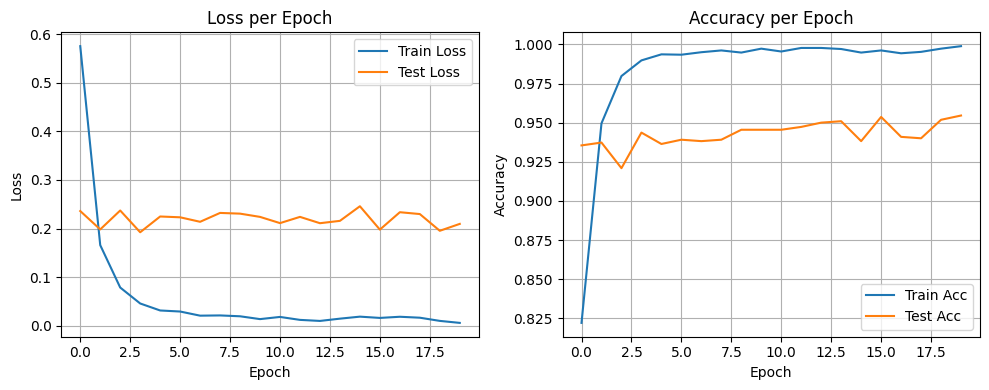

In [44]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

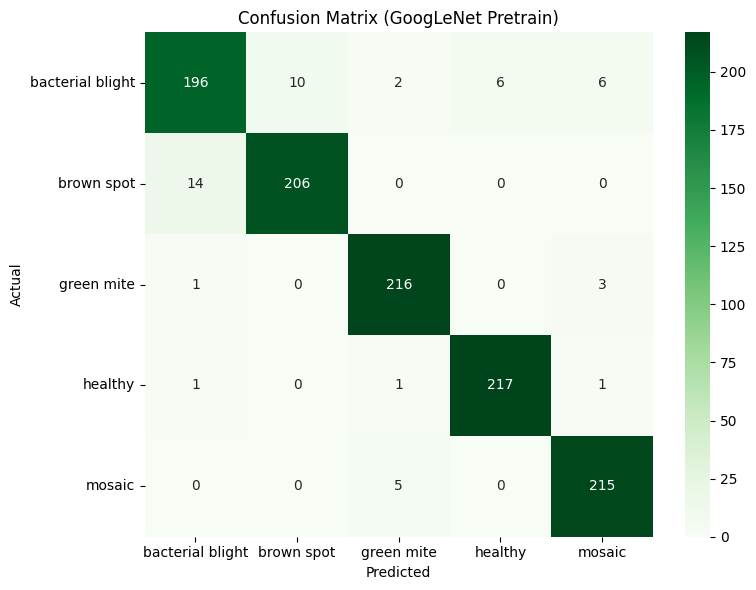

In [45]:
# Confusion Matrix GoogLeNet
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cmgl = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cmgl, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GoogLeNet Pretrain)')
plt.xticks(rotation=0, ha='center')  
plt.yticks(rotation=0)              
plt.tight_layout()  
plt.show()

In [46]:
model.load_state_dict(torch.load("C:/Kuliah/Skripsi/CODE/googlenet_pretrain_model.pth", map_location=device))

C:\Users\P A V I L I O N\AppData\Local\Temp\ipykernel_33516\1857380357.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Kuliah/Skrips

<All keys matched successfully>

In [47]:
model.eval()
all_preds = []
all_labels = []
all_paths = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [48]:
print("\nClassification Report (GoogLeNet Pretrain):")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report (GoogLeNet Pretrain):
                  precision    recall  f1-score   support

bacterial blight       0.92      0.89      0.91       220
      brown spot       0.95      0.94      0.94       220
      green mite       0.96      0.98      0.97       220
         healthy       0.97      0.99      0.98       220
          mosaic       0.96      0.98      0.97       220

        accuracy                           0.95      1100
       macro avg       0.95      0.95      0.95      1100
    weighted avg       0.95      0.95      0.95      1100



In [49]:
# Mendapatkan nama kelas
class_names = sorted(os.listdir(test_path))

# Buat DataFrame
df_results = pd.DataFrame({
    'Actual Label': [class_names[i] for i in all_labels],
    'Predicted Label': [class_names[i] for i in all_preds]
})

print(df_results.head(10))  # Menampilkan 10 prediksi pertama


       Actual Label   Predicted Label
0  bacterial blight  bacterial blight
1  bacterial blight  bacterial blight
2  bacterial blight  bacterial blight
3  bacterial blight  bacterial blight
4  bacterial blight  bacterial blight
5  bacterial blight  bacterial blight
6  bacterial blight  bacterial blight
7  bacterial blight  bacterial blight
8  bacterial blight  bacterial blight
9  bacterial blight  bacterial blight
